In [1]:
import os
from pathlib import Path
import sys
sys.path.insert(0, str(Path(os.getcwd()).parent))
# remove warnings
import warnings
warnings.filterwarnings('ignore')

# %%


# %%
import logging
from financerag.retrieval import BM25Retriever, BM25Processor
import financerag.tasks as tasks_module

import importlib
import inspect
import os
import json
import pandas as pd
from datasets import load_dataset
import numpy as np
from nltk.tokenize import word_tokenize, TweetTokenizer
from rank_bm25 import BM25Okapi
import nltk

import os
import pdb
import re
import shutil
import json
from pathlib import Path
# from dotenv import load_dotenv
from financerag.rerank import CrossEncoderReranker
from sentence_transformers import CrossEncoder
from financerag.retrieval import DenseRetrieval, SentenceTransformerEncoder

tweet_tokenizer = TweetTokenizer()
logging.basicConfig(level=logging.INFO)


In [2]:

# %%
from typing import Any, Callable, Dict, List, Literal, Optional

def tokenize_list_tweet(input_list: List[str]) -> List[List[str]]:
    """
    Tokenizes a list of strings using the `nltk.word_tokenize` function.

    Args:
        input_list (`List[str]`):
            A list of input strings to be tokenized.

    Returns:
        `List[List[str]]`:
            A list where each element is a list of tokens corresponding to an input string.
    """
    return list(map(tweet_tokenizer.tokenize, input_list))


def clean_text(text):
    """
    Replace all Unicode escape sequences (e.g., \u2019, \u0080) with a space.
    """
    return re.sub(r"(\\u[0-9A-Fa-f]{4})+", " ", text)


def load_jsonl(file_path):
    """
    Load a JSONL file and return its content as a list of dictionaries.
    """
    if not file_path.exists():
        raise FileNotFoundError(f"File not found at {file_path}")
    with open(file_path, "r", encoding="utf-8") as f:
        return [json.loads(clean_text(line.strip())) for line in f]



In [3]:

# %%
def first_stage_retrieval(output_dir, task_class, finder_task, ranker_model, dataset_dir = '../data', query_file = '', corpus_file='', overwrite = False, file_name = None):
    ranker_model_changed = ranker_model.replace("/", "_")
    output_dir_name = ranker_model_changed
    # if reranker_model is not None:
    #     output_dir_name += '_'+reranker_model
    if file_name is None:
        if query_file != '':
            output_dir_name += '_'+query_file
        if corpus_file != '':
            output_dir_name += '_'+corpus_file
    else:
        output_dir_name += f'_{file_name}'

    current_output_dir = output_dir+'/'+output_dir_name

    os.makedirs(current_output_dir, exist_ok=True)

    query_file_name = 'queries'
    if query_file != '':
        query_file_name += '_'+query_file
    queries = load_jsonl(Path(f"{dataset_dir}/{task_class.lower()}_queries/{query_file_name}.jsonl"))
    queries_dict = {item['_id']: item['text'] for item in queries}
    finder_task.queries = queries_dict

    corpus_file_name = 'corpus'
    if corpus_file != '':
        corpus_file_name += '_'+corpus_file

    corpus = load_jsonl(Path(f"{dataset_dir}/{task_class.lower()}_corpus/{corpus_file_name}.jsonl"))
    corpus_dict = {item['_id']: {'title': item['title'], 'text': item['text']} for item in corpus}
    top_k = len(corpus_dict)
    finder_task.corpus = corpus_dict

    file_name = f"{current_output_dir}/{task_class}.json"

    if not overwrite:
        if os.path.exists(file_name):
            with open(file_name, "r") as json_file:
                retrieval_result = json.load(json_file)
            return retrieval_result
        
    if ranker_model == 'BM25':
        processor = BM25Processor(tokenizer=tweet_tokenizer.tokenize)
        corpus_documents = [{"title": value["title"], "text": value["text"]} for value in corpus_dict.values()]

        tokenized_corpus = processor.build_corpus(corpus_documents)

        bm25_model = BM25Okapi(tokenized_corpus)
        retrieval_model = BM25Retriever(bm25_model, tokenize_list_tweet)
        
        # Retrieve documents
        retrieval_result = finder_task.retrieve(
            retriever=retrieval_model,
            top_k=top_k
        )
        # Save retrieval result
        
        

    else:
        encoder_model = SentenceTransformerEncoder(
                            model_name_or_path=ranker_model,
                            query_prompt= "Instruct: Given a financial question, relevant passages that best answer the question. \nQuery: ",
                            doc_prompt="Passage: ",
                        )

        retrieval_model = DenseRetrieval(model=encoder_model)

        # Retrieve documents
        retrieval_result = finder_task.retrieve(
                                                retriever=retrieval_model,
                                                top_k=top_k
                                    )

    with open(file_name, "w") as json_file:
            json.dump(retrieval_result, json_file, indent=4)
    
    return retrieval_result

def rerank(output_dir, task_class, finder_task, ranker_model, reranker_model = 'cross-encoder/ms-marco-MiniLM-L-12-v2', dataset_dir = '../data', query_file = '', corpus_file='', overwrite = False, file_name = None):
    ranker_model_changed = ranker_model.replace("/", "_")

    output_dir_name = ranker_model_changed
    if reranker_model is not None:
        output_dir_name += '_'+reranker_model
    if file_name is None:
        if query_file != '':
            output_dir_name += '_'+query_file
        if corpus_file != '':
            output_dir_name += '_'+corpus_file
    else:
        output_dir_name += f'_{file_name}'

    current_output_dir = output_dir+'/'+output_dir_name

    os.makedirs(current_output_dir, exist_ok=True)

    query_file_name = 'queries'
    if query_file != '':
        query_file_name += '_'+query_file
    queries = load_jsonl(Path(f"{dataset_dir}/{task_class.lower()}_queries/{query_file_name}.jsonl"))
    queries_dict = {item['_id']: item['text'] for item in queries}
    finder_task.queries = queries_dict

    corpus_file_name = 'corpus'
    if corpus_file != '':
        corpus_file_name += '_'+corpus_file

    corpus = load_jsonl(Path(f"{dataset_dir}/{task_class.lower()}_corpus/{corpus_file_name}.jsonl"))
    corpus_dict = {item['_id']: {'title': item['title'], 'text': item['text']} for item in corpus}
    finder_task.corpus = corpus_dict

    file_name = f"{current_output_dir}/{task_class}.json"

    if not overwrite:
        if os.path.exists(file_name):
            with open(file_name, "r") as json_file:
                reranking_result = json.load(json_file)
            return reranking_result
    
    retrieval_result = first_stage_retrieval(output_dir, task_class, finder_task, ranker_model, dataset_dir = dataset_dir, query_file = query_file, corpus_file=corpus_file, overwrite = overwrite)

    reranker = CrossEncoderReranker(model=CrossEncoder('cross-encoder/'+reranker_model))
    reranking_result = finder_task.rerank(
                        reranker=reranker,
                        results=retrieval_result,
                        top_k=100,  # Rerank the top 100 documents
                        batch_size=32
                    )
    # Save retrieval result
    with open(file_name, "w") as json_file:
        json.dump(reranking_result, json_file, indent=4)

    return reranking_result



def evaluate(retrieval_result, output_dir, task_class, finder_task, ranker_model, reranker_model = None, dataset_dir = '../data', query_file = '', corpus_file='', file_name = None):
    ranker_model_changed = ranker_model.replace("/", "_")

    output_dir_name = ranker_model_changed
    if reranker_model is not None:
        output_dir_name += '_'+reranker_model
    if file_name is None:
        if query_file != '':
            output_dir_name += '_'+query_file
        if corpus_file != '':
            output_dir_name += '_'+corpus_file
    else:
        output_dir_name += f'_{file_name}'

    current_output_dir = output_dir+'/'+output_dir_name

    # Save evaluation result
    df = pd.read_csv(f'{dataset_dir}/{task_class.split("_")[0]}_qrels.tsv', sep='\t')
    qrels_dict = df.groupby('query_id').apply(lambda x: dict(zip(x['corpus_id'], x['score']))).to_dict()
    eval_result = finder_task.evaluate(qrels_dict, retrieval_result, [1, 5, 10])
    combined_result = {**eval_result[0], **eval_result[1], **eval_result[2], **eval_result[3]}
    df_eval = pd.DataFrame([combined_result])
    df_eval.to_csv(f'{current_output_dir}/{task_class.split("_")[0]}_eval.csv', index=False)

    return df_eval

def evaluate_hybrid(retrieval_result, task_class, finder_task, dataset_dir = '../data', ):


    # Save evaluation result
    df = pd.read_csv(f'{dataset_dir}/{task_class.split("_")[0]}_qrels.tsv', sep='\t')
    qrels_dict = df.groupby('query_id').apply(lambda x: dict(zip(x['corpus_id'], x['score']))).to_dict()
    # print(qrels_dict)
    # print(retrieval_result)
    ndcg = finder_task.evaluate_ndcg(qrels_dict, retrieval_result, [10])
    return ndcg['NDCG@10']


In [4]:

# %%
def normalize(df):  
    return (df - df.min()) / (df.max() - df.min())  
  
def combine_scores(df1, df2, alpha):  
    return alpha * df1 + (1 - alpha) * df2 


In [ ]:

# %%
output_dir = '../results'
ranker_model_1 = 'BM25'
ranker_model_2 = 'intfloat/e5-large-v2'
# reranker_model = None
reranker_model = 'ms-marco-MiniLM-L-12-v2'
dataset_dir = '../data'
query_file = 'para_keyword'
# corpus_file = 'summary_only'
overwrite = False
task_class = 'FinQA'
task_list = ['FinQABench', 'FinDER',  'FinanceBench', 'TATQA', 'FinQA', 'ConvFinQA', 'MultiHiertt']
table_list = [ 'TATQA', 'FinQA', 'ConvFinQA', 'MultiHiertt']

file_name = 'pre_retrieval'

# %%
# Columns of this dataframe should be all task_list
# Index of this dataframe should be alpha values from 0 to 1
# Values should be NDCG@10 scores
master_results = pd.DataFrame(columns=task_list, index=np.linspace(0, 1, 101))


for i, task_class in enumerate(task_list):
    if task_class in table_list:
        corpus_file = 'table'
    else:
        corpus_file = 'summary_only'
    task_class_obj = getattr(tasks_module, task_class)
    finder_task = task_class_obj()
    retrieval_result_1 = first_stage_retrieval(output_dir, task_class, finder_task, ranker_model_1, dataset_dir = '../data', query_file = query_file, corpus_file=corpus_file, overwrite = False, file_name = file_name)
    retrieval_result_2 = first_stage_retrieval(output_dir, task_class, finder_task, ranker_model_2, dataset_dir = '../data', query_file = query_file, corpus_file=corpus_file, overwrite = False, file_name = file_name)

    retrieval_result_1 = pd.DataFrame.from_dict(retrieval_result_1, orient='index')  
    retrieval_result_2 = pd.DataFrame.from_dict(retrieval_result_2, orient='index')  

    results = []
    for alpha in np.linspace(0, 1, 101):
        # Normalize the scores  
        retrieval_result_1_normalized = retrieval_result_1.apply(normalize, axis=1)  
        retrieval_result_2_normalized = retrieval_result_2.apply(normalize, axis=1)  
        # Combine the scores  
        combined_scores = combine_scores(retrieval_result_1_normalized, retrieval_result_2_normalized, alpha) 
        combined_scores_dict = combined_scores.to_dict(orient='index')  
        results.append(evaluate_hybrid(combined_scores_dict, task_class, finder_task, dataset_dir = '../data', ))

    master_results[task_class] = results

    master_results.to_csv(f'{output_dir}/hybrid_results_v2.csv', index=False)

    



In [12]:
output_dir = '../results'
# %%
task_list = ['FinQABench', 'FinDER',  'FinanceBench', 'TATQA', 'FinQA', 'ConvFinQA', 'MultiHiertt']

hybrid_results = pd.read_csv(f'{output_dir}/hybrid_results.csv')
hybrid_results['alpha'] = np.linspace(0, 1, 101)
hybrid_results = hybrid_results.set_index('alpha')


In [13]:

# %%
hybrid_best_results = hybrid_results.idxmax() 
hybrid_best_results


FinQABench      0.06
FinDER          0.13
FinanceBench    0.02
TATQA           0.47
FinQA           0.86
ConvFinQA       0.94
MultiHiertt     0.48
dtype: float64

In [14]:

# %%
hybrid_results.max()


FinQABench      0.87077
FinDER          0.38386
FinanceBench    0.84565
TATQA           0.42619
FinQA           0.48903
ConvFinQA       0.50212
MultiHiertt     0.11649
dtype: float64

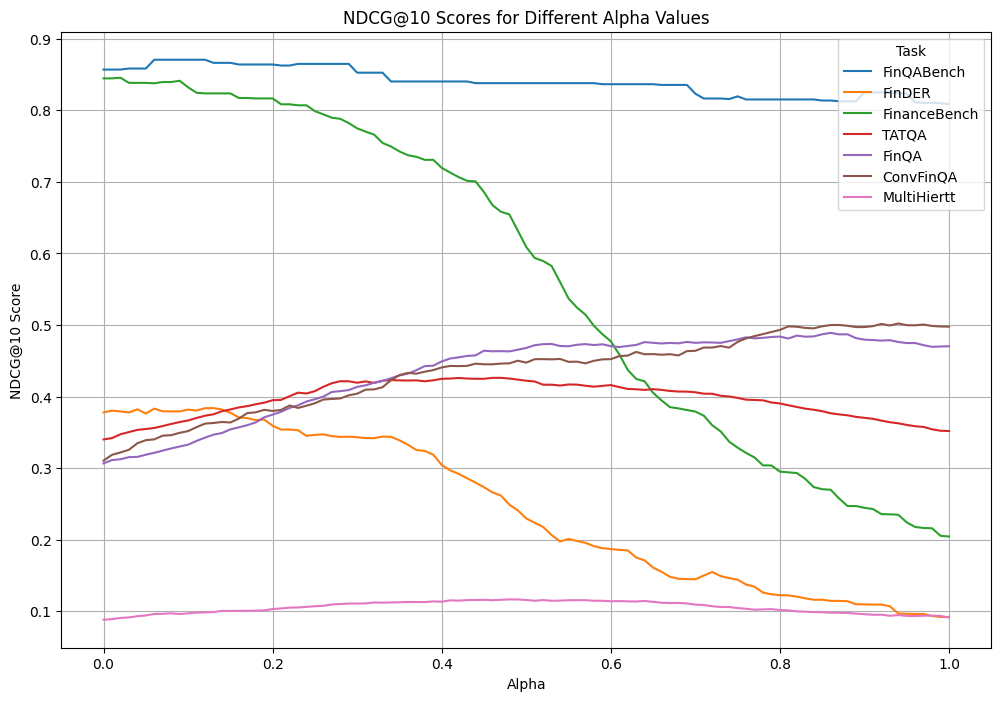

In [15]:


# %%
import matplotlib.pyplot as plt  

plt.figure(figsize=(12, 8))  
  
for task in task_list:  
    plt.plot(hybrid_results.index, hybrid_results[task], label=task)  
  
plt.xlabel('Alpha')  
plt.ylabel('NDCG@10 Score')  
plt.title('NDCG@10 Scores for Different Alpha Values')  
plt.legend(title='Task')  
plt.grid(True)  
plt.show()


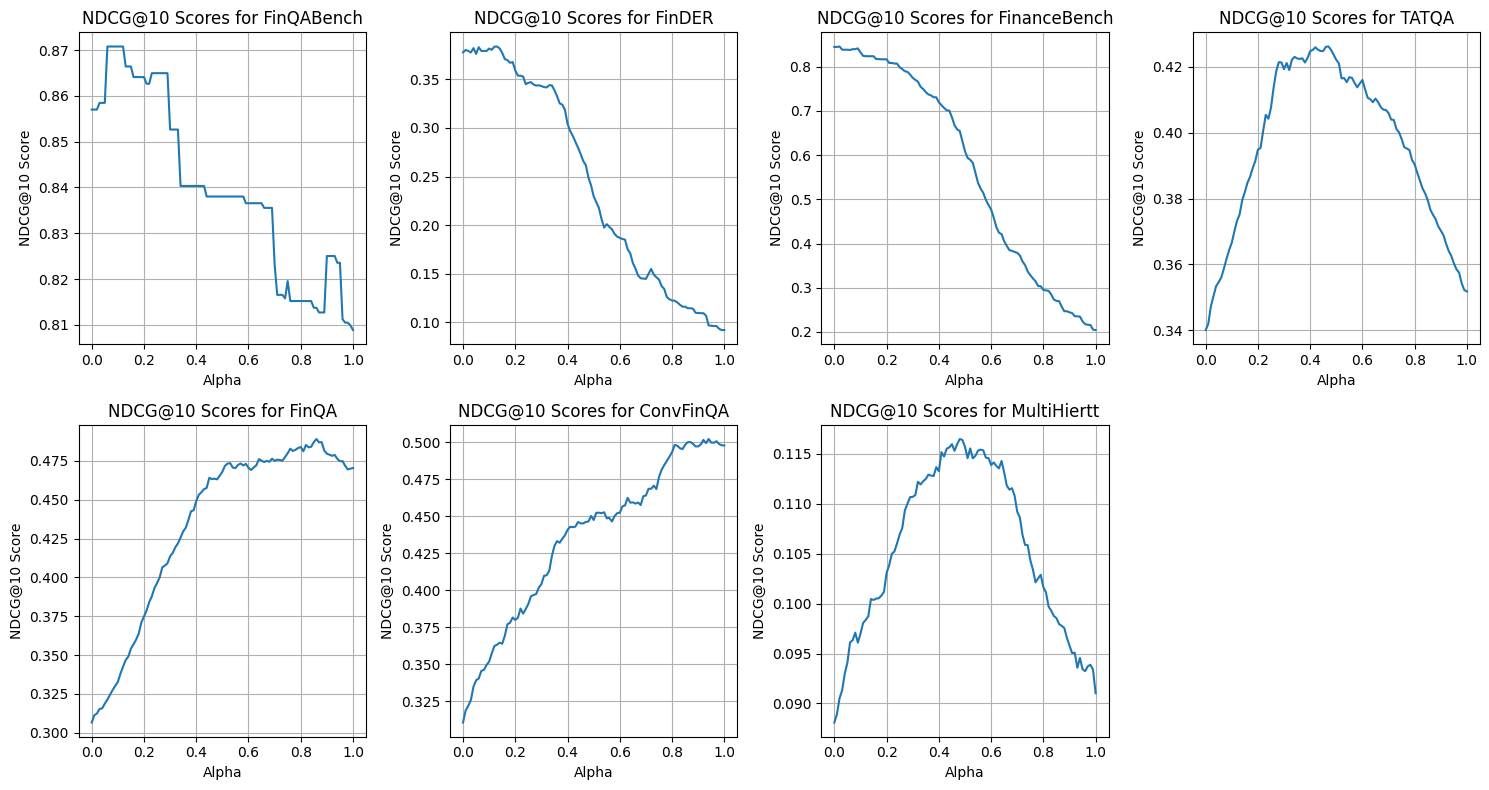

In [16]:

# %%
# Plot the scores for each alpha in subplots  
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))  # Create a 3x3 grid of subplots  
  
# Flatten the axes array for easy iteration  
axes = axes.flatten()  
  
# Plot each task in a separate subplot  
for i, task in enumerate(task_list):  
    ax = axes[i]  
    ax.plot(hybrid_results.index, hybrid_results[task], label=task)  
    ax.set_xlabel('Alpha')  
    ax.set_ylabel('NDCG@10 Score')  
    ax.set_title(f'NDCG@10 Scores for {task}')  
    # ax.legend()  
    ax.grid(True)  
  
# Hide any unused subplots  
for j in range(len(task_list), len(axes)):  
    fig.delaxes(axes[j])  
  
# Adjust layout to prevent overlap  
plt.tight_layout()  
  
# Show the plot  
plt.show()  
